# Gun Detection System for Urban Settings

This notebook contains the implementation of a **gun detection system** for the detection of gunshots sounds in urban settings. The system is designed to detect gunshots by analysing audio data and uses machine learning algorithms to classify the sounds. The proposed system has several potential applications, including the ability to provide real-time information to law enforcement agencies about the location and nature of gunshots. 

In [1]:
import librosa
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import math
from PIL import Image
import os

import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline

First, some constant values are set to be used across the entire notebook

In [2]:
IMG_DIR = "./mel-specs"
VAL_DIR = "./mel-specs-val"
TEST_DIR = "./mel-specs-test"

SAMPLE_RATE = 22050 # Justification for this value is provided later

## Training, validation & testing

In this section both proposed approaches will be implemented using different models for comparison.

***For both of the following approaches, the training data is split equally into ten classes, with only one of them being the target class (gun_shot). Treating this as a binary classification problem by considering only one class as true and all others as false might not result in good classification accuracy, as the correct class will be underrepresented. Therefore, it is better to treat this as a normal classification problem with ten categories. After the classifier predicts the class, the output will be checked for whether it is a gunshot or not. If the predicted class is a gunshot, then it will be considered true; otherwise, it will be considered false.***

Tensorflow 2.11 will be used in this project

In [5]:
!pip install tensorflow==2.11.0

In [6]:
import tensorflow as tf

The following functions will be used for the evaluation and comparison of the different models

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

def _sensitivity(y_actual, y_pred):
    """Calculate the sensitivity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    if(not TP): # avoid Nan values if both TP and FN are 0s
        sensitivity = 0.0
    else:
        sensitivity = (TP / (TP + FN)).round(2)
        
    return sensitivity

def _specificity(y_actual, y_pred):
    """Calculate the specificity score per class for a model"""
    cm = confusion_matrix(y_actual, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    
    if(not TN): # avoid Nan values if both TN and FP are 0s
        specificity = 0.0
    else:
        specificity = (TN / (TN + FP)).round(2)
        
    return specificity

def report(y_actual, y_pred):
    """Print a report with all evaluation metrics for a model"""
    print(classification_report(y_actual, y_pred))
    sensitivity = _sensitivity(y_actual, y_pred)
    print('Sensitivity: ', sensitivity)
    specificity = _specificity(y_actual, y_pred)
    print('Specificity: ', specificity)
    
    cm_matrix = confusion_matrix(y_actual,y_pred)
    sns.heatmap(cm_matrix, annot=True)

### Approach I

This approach involves the classification of mel-spectrogram images representing the audio slices. This moves this task from audio classification into the image classification paradigm. 

For this approach, a 2D deep convolutional neural network (CNN) will be trained on the extracted mel-spectrogram images. To achive this TensorFlow with Keras will be used to construct, train, validate and test the CNN model.

The training, validation and test sets will be loaded from each respective images folder.

In [9]:
'''The training images set'''
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_DIR,
    labels="inferred",
    batch_size=1,
);

Found 7000 files belonging to 10 classes.


In [10]:
'''The validation images set'''
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    batch_size=1,
);

Found 812 files belonging to 10 classes.


In [11]:
'''The testing images set'''
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    batch_size=1,
);

Found 902 files belonging to 10 classes.


In [12]:
for example_spectrograms, example_spect_labels in train_ds.take(1):
    break

The following CNN structure will be used. The CNN takes as an input a 3 channel RGB images. The input layer takes in the image in the original size, then the following layer resizes the images into 32 x 32. Resizing the image reduces the computational complexity of the model. Then, the next layer applies normalization to the image to standardize it. The output then passes through 2 convolutional layers with 16 and 32 filters, respectively. The activation function used is `ReLU`. A max pooling layer then performs a 2x2 pooling operation to reduce the spatial dimensions of the output followed by a dropout layer that randomly drops out 25% of the connections to prevent overfitting. The output is flattened and inputed into a dense layer with 128 nodes. The output goes through another dropout layer with 50% before reaching the last dense layer with ten nodes representing the 10 output classes.

In [13]:
input_shape = example_spectrograms.shape[1:]
num_classes = 10

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    norm_layer,
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes),
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<br/> The model is compiled using adam optimizer and accuracy as evaluation metric.

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

The model is trained with 15 epochs. The validation split will be used for fine tunning.

In [18]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
);

Epoch 1/15


2023-04-07 01:42:33.761602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-07 01:42:34.214479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-07 01:42:35.084285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-07 01:42:35.085275: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbebe264f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-07 01:42:35.085285: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-07 01:42:35.087933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

7000/7000 [==============================] - 23s 3ms/step - loss: 1.5077 - accuracy: 0.4991 - val_loss: 1.0758 - val_accuracy: 0.6330
Epoch 2/15
7000/7000 [==============================] - 21s 3ms/step - loss: 1.0686 - accuracy: 0.6484 - val_loss: 1.0033 - val_accuracy: 0.6810
Epoch 3/15
7000/7000 [==============================] - 20s 3ms/step - loss: 0.8873 - accuracy: 0.7103 - val_loss: 0.8485 - val_accuracy: 0.7229
Epoch 4/15
7000/7000 [==============================] - 21s 3ms/step - loss: 0.7513 - accuracy: 0.7537 - val_loss: 0.8775 - val_accuracy: 0.7217
Epoch 5/15
7000/7000 [==============================] - 21s 3ms/step - loss: 0.6499 - accuracy: 0.7900 - val_loss: 1.0231 - val_accuracy: 0.7241
Epoch 6/15
7000/7000 [==============================] - 21s 3ms/step - loss: 0.5874 - accuracy: 0.8084 - val_loss: 0.9869 - val_accuracy: 0.7414
Epoch 7/15
7000/7000 [==============================] - 21s 3ms/step - loss: 0.5593 - accuracy: 0.8257 - val_loss: 0.9460 - val_accuracy: 0.7

<br/> While training the model, the highest validation accuracy achieved was 75% reached on the 9th epoch with a loss of 0.98. Afterwards, the validation accuracy remained almost the same. The average accuracy of the last 5 epochs was **74.78%**.

To get the true accuracy of the model, it is tested against the test set.

In [19]:
model.evaluate(test_ds, return_dict=True)

902/902 [==============================] - 1s 963us/step - loss: 1.1927 - accuracy: 0.7328


{'loss': 1.1927478313446045, 'accuracy': 0.7328159809112549}

The model scored an accuracy of 73.28% on the test which is an adequate accuracy. However, this value reflects the accuracy of the model across all classes. For the current task, the model should be evaluated on its ability to differentiate between gunshot sounds and all other noises.

To measure the performance of the model with the class of interest, the predicted array will be transformed into a binary array where 1 indicates a predicted gun_shot class and 0 otherwise.

In [20]:
predict = model.predict(test_ds) 
y_pred = np.argmax(predict,axis=1)
y_test = [y.numpy()[0] for x, y in test_ds]

902/902 [==============================] - 1s 872us/step


In [21]:
interest_class = label_map['gun_shot']

y_gun_shot_pred = [1 if x == interest_class else 0 for x in y_pred]
y_gun_shot_test = [1 if x == interest_class else 0 for x in y_test]

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       853
           1       0.12      0.16      0.14        49

    accuracy                           0.89       902
   macro avg       0.54      0.55      0.54       902
weighted avg       0.91      0.89      0.90       902

Sensitivity:  0.16
Specificity:  0.93


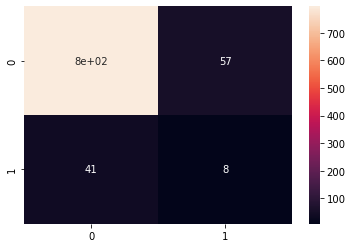

In [22]:
report(y_gun_shot_test, y_gun_shot_pred)

The previous report shows all relevant evaluation metrics for the model's performance with the class of interest. The metrics indicate that the model struggles to recognize gun_shot sounds. Although the model performs well in identifying noises that are not gun shots, it has a very low precision and recall for detecting gun shots, at only 12% precision and 16% recall.

The confusion matrix analysis shows that the model has a high rate of labeling instances as "other" rather than correctly identifying them as gun shots. This suggests that the model is not well-suited for the current task of identifying gun shot sounds.

Based on these results, it is absolutely necessary to consider other approaches to address the challenges of this approach. 

In [23]:
model.save('model_01.h5')

In [24]:
# model = tf.keras.models.load_model('model_01.h5')

---

### Approach II

This approach follows the multi-feature stacking techniques discussed in [[1]](https://www.researchgate.net/publication/365912955_Multi-feature_stacking_order_impact_on_speech_emotion_recognition_performance). This method involves stacking multiple features extracted from the audio clip into a one-dimensional array. Five features will be computed from each audio: Mel-spectrogram, MFCCs, spectral contrast feature, chromagram and tonnetz. Each of these features will be then converted from a 2D matrix to a 1D array by taking the mean across the vertical axis. The authors in [[1]](https://www.researchgate.net/publication/365912955_Multi-feature_stacking_order_impact_on_speech_emotion_recognition_performance) stress the fact that the orders in which these features are stacked is significantly impactful on the final result. Therefore, following their recommended order, the features are horizontally stacked in the following order: spectral contrast, tonnetz, chromagram, Mel-spectrogram, and MFCC. The resulting vectors are then inputted into the classifier. 

The satcked vectors are first loaded in preparation for training.

In [10]:
def load_stacked_feature_arrays(split='train'):
    path = './processed_data/stacked_features'
    
    print('loading {} set...'.format(split), end=' ')
    X = np.loadtxt("{}/X_{}.csv".format(path, split), delimiter=",")
    y = np.loadtxt('{}/y_{}.csv'.format(path, split), delimiter = ',')
    print('done!')
    
    return X, y

In [11]:
X_train, y_train = load_stacked_feature_arrays('train')
X_val, y_val = load_stacked_feature_arrays('val')
X_test, y_test = load_stacked_feature_arrays('test')

loading train set... done!
loading val set... done!
loading test set... done!


---
Two different classification models are trained for comparison, Support vector machine (SVM) and a 1D convolutional neural network (CNN). 

### SVM

To find the best performing set of parameters, a grid search will be performed with scikit-learn's SVC model.

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_estimator = SVC()
svm_parameters = {'C': [0.1,1], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf', 'linear']}
svm = GridSearchCV(svm_estimator, svm_parameters, verbose=3)
svm.fit(X_train, y_train)
svm.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.122 total time=   4.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.159 total time=   3.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.118 total time=   3.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.138 total time=   3.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.131 total time=   4.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.754 total time=  23.7s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.794 total time=  22.6s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.732 total time=  23.5s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.772 total time=  24.1s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.785 total time=  25.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.153 total time=   4.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

SVC(C=0.1, gamma=0.1, kernel='linear')

To validate the resulting model performance, the model is tested against the validation set.

In [10]:
from sklearn.metrics import accuracy_score

y_val_pred = svm.predict(X_val)

print('Model validation accuracy: {}'.format(round(accuracy_score(y_val, y_val_pred), 2)))

Model validation accuracy: 0.75


The model scored a validation accuracy of 75% which is already very promising for the current method. For baseline comparison and further testing the validity of the feature stacking approach, a 1D CNN will be also trained and validated on the same data.

### 1D CNN

The following CNN structure will be used. The CNN takes a one dimenstional input vector equal to the length of the stacked vectors. The input first goes throgh 2 consecutive 1D convolutional layer with ReLU activation function. The output is then randomly dropped to 50% to avoid overfitting before it undergoes pooling. The pooling output is passed to a two consecutive dense layers, the first contains 128 nodes and the last one consists of 10 nodes representing the 10 classes. The CNN is compiled using the adam optimiser and the accuracy will be used as an evaluation metric for fine-tunning.

In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], y_train.shape[0]
input_shape = (n_features, 1)
num_classes = 10

model_1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

2023-04-13 13:30:08.639539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-04-13 13:30:08.639563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: CMPR01
2023-04-13 13:30:08.639569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: CMPR01
2023-04-13 13:30:08.639665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-04-13 13:30:08.639685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-04-13 13:30:08.639691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.161.3 does not match DSO version 470.182.3 -- cannot find working devices in this configuration
2023-04-13 13:30:0

In [13]:
model_1D.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

The model is trained in 20 epochs and the validation sets will be used for model validation.

In [14]:
model_1D.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=1
);

Epoch 1/20
7000/7000 [==============================] - 10s 1ms/step - loss: 1.6684 - accuracy: 0.4647 - val_loss: 1.2205 - val_accuracy: 0.6305
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/step - loss: 1.1230 - accuracy: 0.6320 - val_loss: 0.9726 - val_accuracy: 0.7278
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/step - loss: 0.9327 - accuracy: 0.6994 - val_loss: 0.8971 - val_accuracy: 0.7094
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/step - loss: 0.8276 - accuracy: 0.7411 - val_loss: 0.7775 - val_accuracy: 0.7722
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/step - loss: 0.7463 - accuracy: 0.7649 - val_loss: 0.7141 - val_accuracy: 0.7697
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/step - loss: 0.6741 - accuracy: 0.7861 - val_loss: 0.7591 - val_accuracy: 0.7882
Epoch 7/20
7000/7000 [==============================] - 10s 1ms/step - loss: 0.6236 - accuracy: 0.7974 - val_loss: 0.7190 - val_accurac

While training the model, the highest validation accuracy achieved was 86.33% reached on the 16th epoch with a loss of 0.44. Afterwards, the validation accuracy did not show significant change. The average accuracy of the last 5 epochs was 83.72%.

**This is a higher accuracy than the value achieved by the SVC. This shows a great promise for the multi-feature stacking approach with deep learning.**

## Testing for approach II

Since the CNN model outperformed the SVC model in the validation phase, the CNN is chosen as the better model for the current approach. To further test the suitability of the CNN model for the task at hand, the model is tested against the **test set split**.

In [18]:
from sklearn.metrics import accuracy_score

y_pred = model_1D.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

print('Model validation accuracy: {}%'.format(round(accuracy_score(y_test, y_pred) * 100, 2)))

29/29 [==============================] - 0s 1ms/step
Model validation accuracy: 80.04%


The general accuracy score for the model is 80.04%, however, this does not represent the real accuracy of the model for the gunshot detection task. To measure the performance of the model with the class of interest, the predicted array will be transformed into a binary array where 1 indicates a predicted gun_shot class and 0 otherwise.

In [19]:
interest_class = label_map['gun_shot']

y_gun_shot_pred = [1 if x == interest_class else 0 for x in y_pred]
y_gun_shot_test = [1 if x == interest_class else 0 for x in y_test]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       853
           1       0.98      0.86      0.91        49

    accuracy                           0.99       902
   macro avg       0.98      0.93      0.95       902
weighted avg       0.99      0.99      0.99       902

Sensitivity:  0.86
Specificity:  1.0


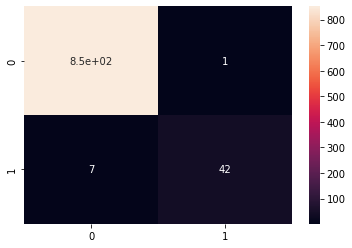

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

report(y_gun_shot_test, y_gun_shot_pred)

Based on the evaluation metrics presented in the previous report, the CNN model for gunshot detection achieved excellent results. The model was able to discriminate between the gun_shot class and all other classes with nearly perfect scores, resulting in an overall accuracy of 99%. The model also showed strong sensitivity (or recall) with a score of 86%, indicating that the model can accurately detect most instances of gun_shot sounds. In addition, the model demonstrated a perfect specificity, which means that it mostly did not misclassify any non-gun_shot sounds as gun_shot sounds. These results suggest that the CNN model is highly effective at detecting gun_shot sounds, and could be a valuable tool in identifying and responding to potential gun-related incidents.

In [22]:
model_1D.save('model_02.h5')

In [23]:
# model_1D = tf.keras.models.load_model('model_02.h5')

# Inferencing

Although the model is already tested on the test split, which was unseen by the model before, it is also necessary to evaluate the model performance with data obtained outside of the current dataset.

In this step, the trained model is applied to fresh, unseen data to evaluate its performance in real-world scenarios. This phase involves testing the model on a sample of data that was not previously used in the training, validation or testing phases.

In the current project, the model is tested on 10 different sound clips downloaded from YouTube in mp3 format. This is a small sample due to the limited time available for the project, but it serves as an experiment to assess how the model would perform with real-world data. The 10 sound clips belong to different classes, but not all classes are represented in the sample. Some of the sound clips contain gunshot sounds representing the target class. The performance of the model on these sound clips can help evaluate its efficacy in detecting gunshot sounds in real-world scenarios.

In [10]:
INFERENCING_DIR = './inferencing_set'

The files are loaded into a numpy array to prepare for inferencing. The sounds are loaded as 2-second-segments. If a sound is smaller, it is padded with silence. If the sound is longer, the first 2 seconds are taken. The original sound files all have a lengths of few ms seconds less or more than 2 seconds; thus, the lengths are not greatly affected.

In [11]:
files = librosa.util.find_files(INFERENCING_DIR, ext=['mp3'])
files = np.asarray(files)
LEN = 44100

inf_slices = []
inf_labels = []

for file in files:
    if '.mp3' in file:
        filename = file.split('/').pop()
        label = filename.split('.')[0].split('-')[1] # class ID
        wave_arr, sr = librosa.load(file, sr = SAMPLE_RATE, mono = True)
        
        if len(wave_arr) < 44100:
            diff = LEN - len(wave_arr)
            silence = np.zeros(diff) # silence
            lead = silence[0 : math.ceil(diff / 2)]
            trail = silence[0 : math.floor(diff / 2)]
            
            wave_arr = np.concatenate((lead, wave_arr, trail))
        
        inf_slices += [wave_arr.astype(float)[:LEN]]
        inf_labels += [int(label)]
        
inf_slices = np.array(inf_slices, dtype=np.float)
y_inf = np.array(inf_labels)

inf_slices.shape

(10, 44100)

The next step is to extract the stacked features vectors.

In [12]:
print('Inferencing set stacked features: ', end='')
X_stack_inf = extract_stacked_feature_arrays(inf_slices)

Inferencing set stacked features: extracting........done!


Next, the model is loaded then the sounds arrays passed to the model for prediction.

In [13]:
model = tf.keras.models.load_model('model_02.h5')

2023-04-14 01:29:43.042701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-04-14 01:29:43.042764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: CMPR01
2023-04-14 01:29:43.042781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: CMPR01
2023-04-14 01:29:43.043002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-04-14 01:29:43.043061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-04-14 01:29:43.043076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.161.3 does not match DSO version 470.182.3 -- cannot find working devices in this configuration
2023-04-14 01:29:4

In [14]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_stack_inf)
y_pred = np.argmax(y_pred,axis=1)

1/1 [==============================] - 0s 96ms/step


In [15]:
interest_class = label_map['gun_shot']

y_gun_shot_pred = [1 if x == interest_class else 0 for x in y_pred]
y_gun_shot_test = [1 if x == interest_class else 0 for x in y_inf]

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10

Sensitivity:  0.5
Specificity:  1.0


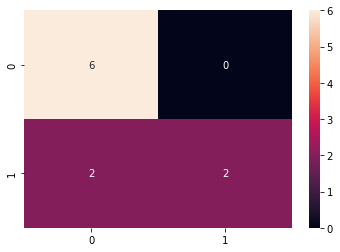

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

report(y_gun_shot_test, y_gun_shot_pred)

The previous report shows all evaluation metrics for the quality of the inferencing of the model. It is clear that the model achieved an excellent accuracy of 80%, which is a promising outcome. However, this value is lower than the accuracy score obtained on the test set, which was 99%. This variation is not unusual since the test set consists of carefully curated data that the model had never encountered before but they are extracted from the same sources. Whereas the fresh data in the inference phase is pulled from the internet and may contain variables that the model has not been trained on.

The report also shows that the model was successful in predicting the target class with 100% precision. This means that of all the instances predicted as the target class, every single one was correct. However, the recall score for the target class was only 50%. This means that the model correctly identified only half of the actual target class instances in the sample. This could indicate that the model is not as sensitive to detecting the target class as it should be, and may require further fine-tuning or adjustment to improve its performance in this area.

# Discussion

The 1D multi-feature stacking technique proves to be superior to the image mel-spectrogram classification in detecting noise in the given task. The accuracy achieved by the SVC classifier and 1D CNN surpassed that of the 2D CNN in Approach I. Furthermore, when assessing the model's ability to identify the class of interest as opposed to all other classes, the superiority of the 1D multi-feature stacking technique becomes even more apparent. Combining all other classes into a single class showed that the first approach struggled to identify the majority of instances of the target class.

The poor performance of the first approach could be due to many reasons including the nature of the gun_shot class. Gunshots are loud and quick. Other types of noises, such as children_playing, happen continously over an extended period of time and they have a relevantly smooth beginning and end. On the other hand, gunshots occur suddenly and their sounds go from extremely low frequency (zero if no background noise is present) to a momentarily very high frequency then back to low frequency again. This results in mel-spectrograms similar to the two examples displayed below. As seen below, the images are mostly black with a small portion of sound variation. Similar images might be confusing for the CNN as they don't provide a big variation in features and they are mostly blank. This might caused the CNN to struggle in learning the right features for the interest class. 

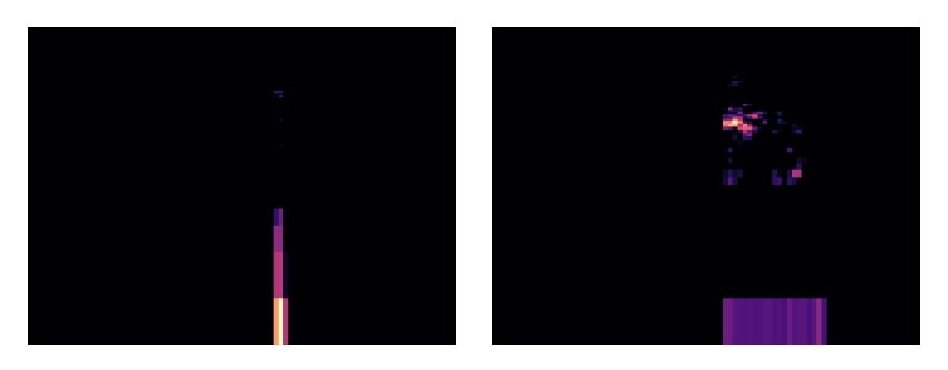

Furthermore, computer vision tasks require a huge amount of data in order to achieve satisfactory results. The training set included 700 instances per class which is relatively small for similar tasks. More instances and more variation of sound environments could benifit the model for a better detection accuracy.

The multi-feature stacking solves those issues by providing much more data about each sound. This approach provides a more comprehensive understanding of each sound, enhancing the model's ability to classify them accurately. By combining the knowledge gained from mel-spectrogram representations with other audio features, the model gains greater insight into the nature of the sound and its various aspects, resulting in improved classification performance.

# Conclusion

This notebook details the implementation of a gunshot detection system using deep learning. A dataset of 8732 labelled sound files divided into 10 different classes was used. The necessary data preprocessing techniques are applied to the data to prepare for training and to address some issues with the data such as the class imbalance. 

Two approaches were tested for the task, with the first one involving the conversion of sound files into mel-spectrogram images. A 2D CNN model was then trained and evaluated on these images for mel-spectrogram image classification. Although the model achieved a 73% accuracy in classifying sounds into any of the ten classes, it performed poorly in identifying the target class, i.e., gunshot sounds. Therefore, this approach was found unsuitable for the current task.

The second approach for the gunshot detection system involves extracting five distinct 2D features from each sound instance. These features are then transformed into 1D vectors by averaging across the x-axis, and subsequently stacked in a particular order to form a long 1D vector representing the sound instance. Two models were trained using this approach, SVC and 1D CNN. During the validation phase, both models demonstrated impressive results, with the CNN outperforming the SVC with validation accuracy scores of 86% and 75%, respectively. The CNN model was then evaluated on the test set, and it produced remarkable outcomes.

The CNN model achieved an overall classification accuracy of 80% in identifying sounds among the ten classes. However, when examined for the target class, the model demonstrated a 99% accuracy in distinguishing gunshot sounds from all other classes. This result confirms that this approach utilizing deep learning is the most appropriate for the given task.

When applied to fresh unseen sound clips pulled from the internet, the 1D CNN achieved an accuracy of 80%. While this value is lower than the accuracy score obtained on the test set, it is still a satisfactory result. The precision score for the target class was 100%, however, the recall score for the target class was only 50%, suggesting that the model may require further improvement to increase its sensitivity to detecting the target class.

# References

\[1\]   Y. Tanoko and A. Zahra, “Multi-feature stacking order impact on speech emotion recognition performance,” Bulletin of Electrical Engineering and Informatics, vol. 11, no. 6, pp. 3272–3278, Dec. 2022, doi: 10.11591/EEI.V11I6.4287.